### <center> **Variational Inference**
#### <center> **Turing.jl**
**References:**    
https://turinglang.org/docs/tutorials/variational-inference/  
https://turinglang.org/AdvancedVI.jl/dev/tutorials/basic/  
https://turinglang.org/docs/developers/inference/variational-inference/  
https://turinglang.org/AdvancedVI.jl/dev/families/  
https://github.com/TuringLang/AdvancedVI.jl

In [1]:
include("C:/Users/mussi/Documents/Manhattan/Leuven/MCQMC/Data_Libraries/1.Libraries_setup.jl")

using Random
using Turing
using AdvancedVI
using FillArrays
using RDatasets
using Optimisers
using QuasiMonteCarlo
using DiffResults
using DynamicPPL  
using Zygote    
using ADTypes
using LogDensityProblems
using Distributions
using DataFrames
using StatsFuns
using Bijectors: Bijectors
using LogDensityProblemsAD
using ForwardDiff
Pkg.status("AdvancedVI")

  Activating project at `C:\Users\mussi\Documents\Manhattan\Leuven\MCQMC\Data_Libraries`


Status `C:\Users\mussi\Documents\Manhattan\Leuven\MCQMC\Data_Libraries\Project.toml`
⌅ [b5ca4192] AdvancedVI v0.4.1
Info Packages marked with ⌅ have new versions available but compatibility constraints restrict them from upgrading. To see why use `status --outdated`


In [2]:
data = RDatasets.dataset("datasets", "mtcars");
first(data, 6)

# Function to split samples.
function split_data(df, at=0.70)
    r = size(df, 1)
    index = Int(round(r * at))
    train = df[1:index, :]
    test = df[(index + 1):end, :]
    return train, test
end

# A handy helper function to rescale our dataset.
function standardize(x)
    return (x .- mean(x; dims=1)) ./ std(x; dims=1)
end

function standardize(x, orig)
    return (x .- mean(orig; dims=1)) ./ std(orig; dims=1)
end

# Another helper function to unstandardize our datasets.
function unstandardize(x, orig)
    return x .* std(orig; dims=1) .+ mean(orig; dims=1)
end

function unstandardize(x, mean_train, std_train)
    return x .* std_train .+ mean_train
end

# Remove the model column.
select!(data, Not(:Model))

# Split our dataset 70%/30% into training/test sets.
train, test = split_data(data, 0.7)
train_unstandardized = copy(train)

# Standardize both datasets.
std_train = standardize(Matrix(train))
std_test = standardize(Matrix(test), Matrix(train))

# Save dataframe versions of our dataset.
train_cut = DataFrame(std_train, names(data))
test_cut = DataFrame(std_test, names(data))

# Create our labels. These are the values we are trying to predict.
train_label = train_cut[:, :MPG]
test_label = test_cut[:, :MPG]

# Get the list of columns to keep.
remove_names = filter(x -> !in(x, ["MPG"]), names(data))

# Filter the test and train sets.
train = Matrix(train_cut[:, remove_names]);
test = Matrix(test_cut[:, remove_names]);

In [3]:
# Bayesian linear regression.
@model function linear_regression(x, y, n_obs, n_vars, ::Type{T}=Vector{Float64}) where {T}
    # Set variance prior.
    σ² ~ truncated(Normal(0, 100); lower=0)

    # Set intercept prior.
    intercept ~ Normal(0, 3)

    # Set the priors on our coefficients.
    coefficients ~ MvNormal(Zeros(n_vars), 10.0 * I)

    # Calculate all the mu terms.
    mu = intercept .+ x * coefficients
    return y ~ MvNormal(mu, σ² * I)
end;

n_obs, n_vars = size(train)
m = linear_regression(train, train_label, n_obs, n_vars);

To run VI, we must first set a variational family. For instance, the most commonly used family is the mean-field Gaussian family. For this, Turing provides functions that automatically construct the initialization corresponding to the model m.   
The main output of the algorithm is q_avg, the average of the parameters generated by the optimization algorithm. For computing q_avg, the default setting uses what is known as polynomial averaging. Usually, q_avg will perform better than the last-iterate q_last

In [4]:
n_iters = 1000
q_avg, q_last, info, state = vi(m, q_meanfield_gaussian(m), n_iters; show_progress=false);

Now, info contains information generated during optimization that could be useful for diagnostics. For the default setting, which is RepGradELBO, it contains the ELBO estimated at each step, which can be plotted as follows:

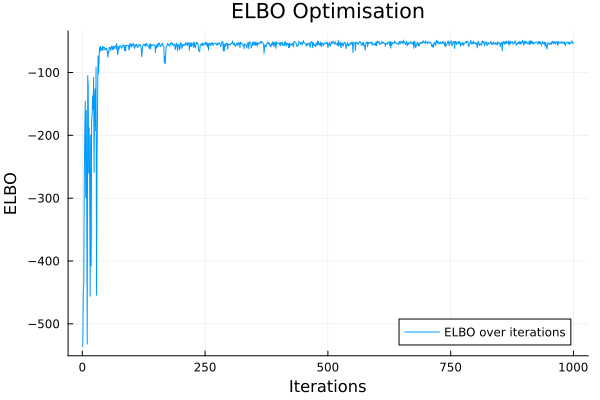

In [5]:
plot([i.elbo for i in info], xlabel="Iterations", ylabel="ELBO", label="ELBO over iterations", title="ELBO Optimisation")

In [6]:
function callback(; stat, averaged_params, restructure, kwargs...)
    if mod(stat.iteration, 10) == 1
        q_avg = restructure(averaged_params)
        obj = AdvancedVI.RepGradELBO(128)
        elbo_avg = estimate_objective(obj, q_avg, LogDensityFunction(m))
        (elbo_avg = elbo_avg,)
    else
        nothing
    end
end;

q_mf, _, info_mf, _ = vi(m, q_meanfield_gaussian(m), n_iters; show_progress=false, callback=callback);

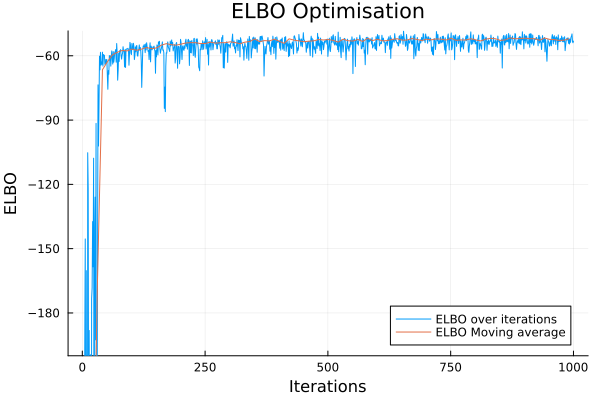

In [7]:
iters = 1:10:length(info_mf)
elbo_mf = [i.elbo_avg for i in info_mf[iters]]
plot([i.elbo for i in info], xlabel="Iterations", ylabel="ELBO", label="ELBO over iterations", title="ELBO Optimisation")
plot!(iters, elbo_mf, xlabel="Iterations", ylabel="ELBO", label="ELBO Moving average", ylims=(-200,Inf))

The default optimiser we use is a proximal variant of DoWG18. For Gaussian variational families, this works well as a default option. Sometimes, the step size of AdvancedVI.DoWG could be too large, resulting in unstable behavior. (In this case, we recommend trying AdvancedVI.DoG19) Or, for whatever reason, it might be desirable to use a different optimiser. Our implementation supports any optimiser that implements the Optimisers.jl interface. For instance, let’s try using Optimisers.Adam20, which is a popular choice. Since AdvancedVI does not implement a proximal operator for Optimisers.Adam, we must use the AdvancedVI.ClipScale() projection operator, which ensures that the scale matrix of the variational approximation is positive definite.

In [8]:
_, _, info_adam, _ = vi(m, q_meanfield_gaussian(m), n_iters; show_progress=false, callback=callback, optimizer=Optimisers.Adam(3e-3), operator=ClipScale());

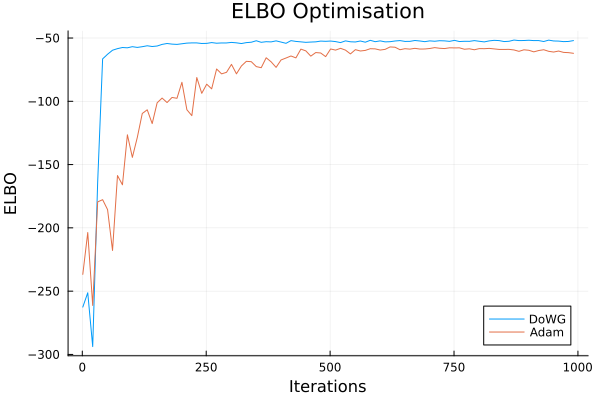

In [9]:
iters = 1:10:length(info_mf)
elbo_adam = [i.elbo_avg for i in info_adam[iters]]
plot(iters, elbo_mf, xlabel="Iterations", ylabel="ELBO", label="DoWG", title="ELBO Optimisation")
plot!(iters, elbo_adam, xlabel="Iterations", ylabel="ELBO", label="Adam")

The term full-rank might seem a bit peculiar since covariance matrices are always full-rank. This term, however, traditionally comes from the fact that full-rank families use full-rank factors in addition to the diagonal of the covariance.

In [10]:
q_init_fr = q_fullrank_gaussian(m);
q_fr, _, info_fr, _ = vi(m, q_init_fr, n_iters; show_progress=false, callback);

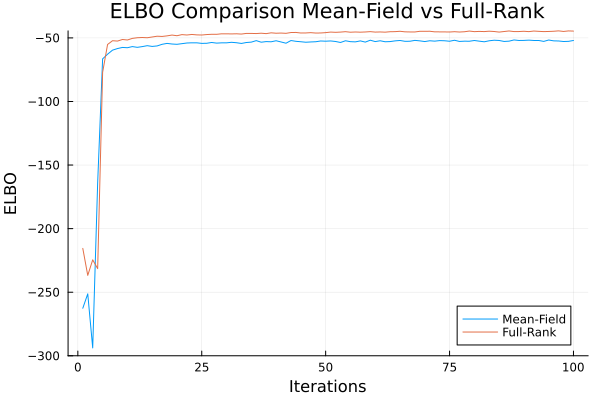

In [11]:
plot(elbo_mf, xlabel="Iterations", ylabel="ELBO", label="Mean-Field", ylims=(-200, Inf), title="ELBO Comparison Mean-Field vs Full-Rank")
plot!([i.elbo_avg for i in info_fr[iters]], xlabel="Iterations", ylabel="ELBO", label="Full-Rank", ylims=(-300, Inf))

However, we can see that the full-rank families achieve a higher ELBO in the end. Due to the relationship between the ELBO and the Kullback-Leibler divergence, this indicates that the full-rank covariance is much more accurate. This trade-off between statistical accuracy and optimization speed is often referred to as the statistical-computational trade-off. The fact that we can control this trade-off through the choice of variational family is a strength, rather than a limitation, of variational inference.

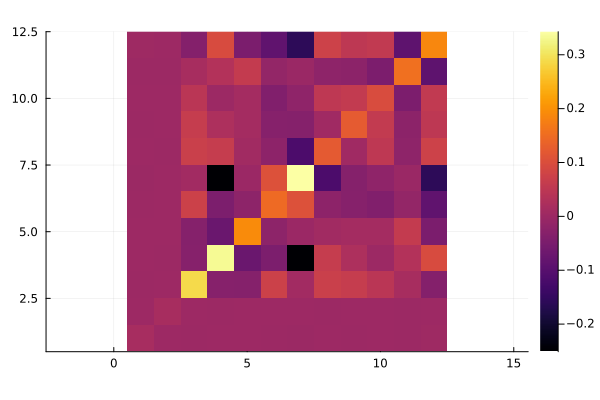

In [12]:
heatmap(cov(rand(q_fr, 100_000), dims=2),aspect_ratio=1)

In [12]:
# Posterior Mean
z = rand(q_fr, 100_000);
avg = vec(mean(z; dims=2))

12-element Vector{Float64}:
  0.3675995838803076
  0.001245321442496712
  0.3516933254160916
 -0.09308798104552903
 -0.0694939269152878
  0.593648139705928
 -0.024290028482271873
  0.07630900518644025
 -0.05747278624158018
  0.126048562577794
  0.1838027072336827
 -0.599317465042744

In [16]:
# OLS using formula
train_cut.MPG_label = train_label
formula = StatsModels.Term(:MPG_label) ~ sum(StatsModels.Term.(Symbol.(remove_names)))
@time ols = lm(formula, train_cut)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

MPG_label ~ 1 + Cyl + Disp + HP + DRat + WT + QSec + VS + AM + Gear + Carb

Coefficients:
─────────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error      t  Pr(>|t|)   Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────
(Intercept)   7.6818e-16   0.0847835   0.00    1.0000  -0.186607   0.186607
Cyl           0.384278     0.368606    1.04    0.3195  -0.427019   1.19557
Disp         -0.115358     0.386343   -0.30    0.7708  -0.965693   0.734977
HP           -0.0782581    0.299468   -0.26    0.7987  -0.737382   0.580865
DRat          0.622413     0.261667    2.38    0.0366   0.0464889  1.19834
WT            0.0130119    0.386276    0.03    0.9737  -0.837175   0.863199
QSec          0.0770157    0.227272    0.34

  6.171277 seconds (14.19 M allocations: 696.725 MiB, 21.83% gc time, 99.73% compilation time: <1% of which was recompilation)


In [14]:
function plot_variational_marginals(z, sym2range)
    ps = []

    for (i, sym) in enumerate(keys(sym2range))
        indices = union(sym2range[sym]...)  # <= array of ranges
        if sum(length.(indices)) > 1
            offset = 1
            for r in indices
                for j in r
                    p = density(
                        z[j, :]; title="$(sym)[$offset]", titlefontsize=10, label=""
                    )
                    push!(ps, p)

                    offset += 1
                end
            end
        else
            p = density(z[first(indices), :]; title="$(sym)", titlefontsize=10, label="")
            push!(ps, p)
        end
    end

    return plot(ps...; layout=(length(ps), 1), size=(500, 1500))
end

plot_variational_marginals (generic function with 1 method)

In [15]:
varinf = Turing.DynamicPPL.VarInfo(m)
vns_and_values = Turing.DynamicPPL.varname_and_value_leaves(Turing.DynamicPPL.values_as(varinf, OrderedDict))
varnames = map(first, vns_and_values)
vi_chain = Chains(reshape(z', (size(z,2), size(z,1), 1)), varnames)

Chains MCMC chain (100000×12×1 reshape(adjoint(::Matrix{Float64}), 100000, 12, 1) with eltype Float64):

Iterations        = 1:1:100000
Number of chains  = 1
Samples per chain = 100000
parameters        = σ², intercept, coefficients[1], coefficients[2], coefficients[3], coefficients[4], coefficients[5], coefficients[6], coefficients[7], coefficients[8], coefficients[9], coefficients[10]

Use `describe(chains)` for summary statistics and quantiles.


In [16]:
z_mf = rand(q_mf, 10_000);
z_fr = rand(q_fr, 10_000);

vi_mf_chain = Chains(reshape(z_mf', (size(z_mf,2), size(z_mf,1), 1)), varnames);
vi_fr_chain = Chains(reshape(z_fr', (size(z_fr,2), size(z_fr,1), 1)), varnames);

function prediction(chain, x)
    p = get_params(chain)
    α = mean(p.intercept)
    β = collect(mean.(p.coefficients))
    return α .+ x * β
end

train_cut.VIMFPredictions = unstandardize(
    prediction(vi_mf_chain, train), train_unstandardized.MPG
)
test_cut.VIMFPredictions = unstandardize(
    prediction(vi_mf_chain, test), train_unstandardized.MPG
)

train_cut.VIFRPredictions = unstandardize(
    prediction(vi_fr_chain, train), train_unstandardized.MPG
)
test_cut.VIFRPredictions = unstandardize(
    prediction(vi_fr_chain, test), train_unstandardized.MPG
)

vi_mf_loss1 = mean((train_cut.VIMFPredictions - train_cut.MPG) .^ 2)
vi_fr_loss1 = mean((train_cut.VIFRPredictions - train_cut.MPG) .^ 2)

vi_mf_loss2 = mean((test_cut.VIMFPredictions - test_cut.MPG) .^ 2)
vi_fr_loss2 = mean((test_cut.VIFRPredictions - test_cut.MPG) .^ 2)

println("Training set:
    VI Mean-Field loss: $vi_mf_loss1
    VI Full-Rank loss: $vi_fr_loss1
Test set:
    VI Mean-Field loss: $vi_mf_loss2
    VI Full-Rank loss: $vi_fr_loss2")

Training set:
    VI Mean-Field loss: 422.8924082209401
    VI Full-Rank loss: 422.9543346976077
Test set:
    VI Mean-Field loss: 490.70863411669507
    VI Full-Rank loss: 490.3133868798077


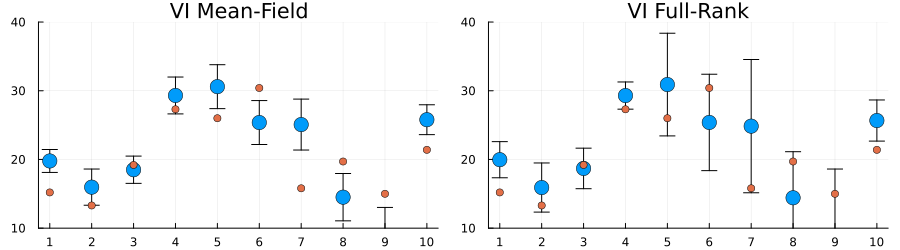

In [17]:
preds_vi_mf = mapreduce(hcat, 1:5:size(vi_mf_chain, 1)) do i
    return unstandardize(prediction(vi_mf_chain[i], test), train_unstandardized.MPG)
end

p1 = scatter(
    1:size(test, 1),
    mean(preds_vi_mf; dims=2);
    yerr=std(preds_vi_mf; dims=2),
    label="prediction (mean ± std)",
    size=(900, 500),
    markersize=8,
)
scatter!(1:size(test, 1), unstandardize(test_label, train_unstandardized.MPG); label="true")
xaxis!(1:size(test, 1))
ylims!(10, 40)
title!("VI Mean-Field")

preds_vi_fr = mapreduce(hcat, 1:5:size(vi_mf_chain, 1)) do i
    return unstandardize(prediction(vi_fr_chain[i], test), train_unstandardized.MPG)
end

p2 = scatter(
    1:size(test, 1),
    mean(preds_vi_fr; dims=2);
    yerr=std(preds_vi_fr; dims=2),
    label="prediction (mean ± std)",
    size=(900, 500),
    markersize=8,
)
scatter!(1:size(test, 1), unstandardize(test_label, train_unstandardized.MPG); label="true")
xaxis!(1:size(test, 1))
ylims!(10, 40)
title!("VI Full-Rank")

plot(p1, p2; layout=(1, 2), size=(900, 250), label="")

#### <center> **ELBO Maximisation**  
https://turinglang.org/AdvancedVI.jl/v0.4/examples/

In [3]:
struct NormalLogNormal{MX,SX,MY,SY}
    # Log-normal Prior
    μ_x::MX
    σ_x::SX
    # Multivariate Normal Prior
    μ_y::MY
    Σ_y::SY
end

function LogDensityProblems.logdensity(model::NormalLogNormal, θ)
    (; μ_x, σ_x, μ_y, Σ_y) = model
    return logpdf(LogNormal(μ_x, σ_x), θ[1]) + logpdf(MvNormal(μ_y, Σ_y), θ[2:end])
end

function LogDensityProblems.dimension(model::NormalLogNormal)
    return length(model.μ_y) + 1
end

function LogDensityProblems.capabilities(::Type{<:NormalLogNormal})
    return LogDensityProblems.LogDensityOrder{0}()
end

In [37]:
n_dims = 10
μ_x = randn()
σ_x = exp.(randn())
μ_y = randn(n_dims)
σ_y = exp.(randn(n_dims))
model = NormalLogNormal(μ_x, σ_x, μ_y, Diagonal(σ_y .^ 2));
nothing

Since the y follows a log-normal prior, its support is bounded to be the positive half-space R_+. Thus, we will use Bijectors to match the support of our target posterior and the variational approximation, which is estimated on an unconstrained space.

In [ ]:
using Bijectors

function Bijectors.bijector(model::NormalLogNormal)
    (; μ_x, σ_x, μ_y, Σ_y) = model
    return Bijectors.Stacked( Bijectors.bijector.([LogNormal(μ_x, σ_x), MvNormal(μ_y, Σ_y)]), [1:1, 2:(1 + length(μ_y))],)
end

b = Bijectors.bijector(model);          # From the unconstrained to the constrained parameter space
binv = Bijectors.inverse(b)
nothing

d = LogDensityProblems.dimension(model);
μ = randn(d);
L = Diagonal(ones(d));
# Unconstrained Sampling 
q0 = AdvancedVI.MeanFieldGaussian(μ, L)
nothing

ClipScale is a projection operator, which ensures that the variational approximation stays within a stable region of the variational family. More precisely it prevents the covariance matrix to be negative-definite. 

In [ ]:
# Closed-form Entropy
n_montecaro = 10;
objective = RepGradELBO(n_montecaro)                         # RepGradELBO(entropy=ClosedFormEntropy(), n_samples=10) 

# Constrained Sampling 
q0_trans = Bijectors.TransformedDistribution(q0, binv)

function callback(; stat, averaged_params, restructure, kwargs...)
    if mod(stat.iteration, 100) == 1
        q_avg = restructure(averaged_params)
        obj_eval = AdvancedVI.RepGradELBO(128)
        elbo_avg = AdvancedVI.estimate_objective(obj_eval, q_avg, model)
        (elbo_avg = elbo_avg,)
    else
        nothing
    end
end;

n_max_iter = 10^4
q_avg_trans, q_trans, stats, _ = AdvancedVI.optimize(model, objective, q0_trans, n_max_iter; show_progress=false, adtype=AutoForwardDiff(), 
                                                     optimizer=Optimisers.Adam(1e-3), operator=ClipScale(), callback=callback, );
nothing

q_avg_trans is the final output of the optimization procedure. If a parameter averaging strategy is used through the keyword argument averager, q_avg_trans is be the output of the averaging strategy, while q_trans is the last iterate.

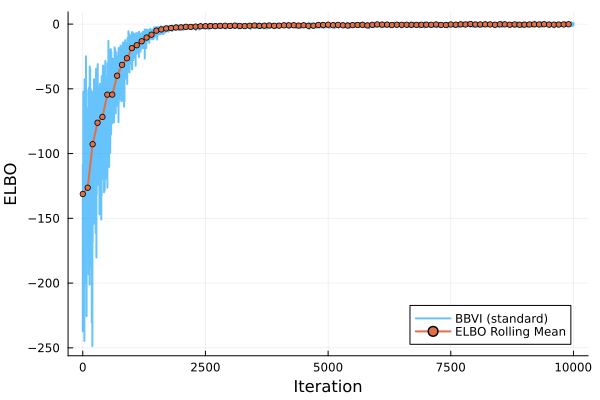

In [41]:
t = [stat.iteration for stat in stats]
y = [stat.elbo for stat in stats]
plot(t, y; label="BBVI (standard)", xlabel="Iteration", ylabel="ELBO", linewidth=2, alpha=0.6)

iters_callback = [stat.iteration for stat in stats if haskey(stat, :elbo_avg)]
elbo_callback = [stat.elbo_avg for stat in stats if haskey(stat, :elbo_avg)]

plot!(iters_callback, elbo_callback, xlabel="Iteration", ylabel="ELBO",  label="ELBO Rolling Mean", linewidth=2, marker=:circle, markersize=3, legend=:bottomright)

In [40]:
# ELBO Estimation
estimate_objective(objective, q_avg_trans, model; n_samples=10^4)

-0.18102070465369025

In [43]:
n_montecarlo = 10
repgradelbo_MC = AdvancedVI.RepGradELBO(n_montecarlo; entropy=AdvancedVI.MonteCarloEntropy());
nothing

n_max_iter = 5000
q_avg_trans, q_trans, stats, _ = AdvancedVI.optimize( model, repgradelbo_MC, q0_trans, n_max_iter; 
                                                      show_progress=false, adtype=AutoForwardDiff(), 
                                                      optimizer=Optimisers.Adam(1e-3), callback=callback, );
nothing


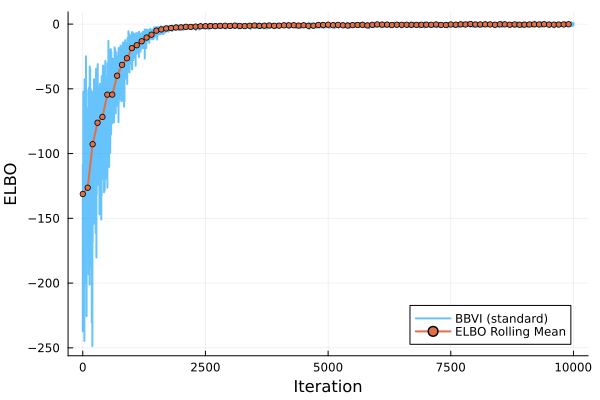

In [42]:
t = [stat.iteration for stat in stats]
y = [stat.elbo for stat in stats]
plot(t, y; label="BBVI (standard)", xlabel="Iteration", ylabel="ELBO", linewidth=2, alpha=0.6)

iters_callback = [stat.iteration for stat in stats if haskey(stat, :elbo_avg)]
elbo_callback = [stat.elbo_avg for stat in stats if haskey(stat, :elbo_avg)]

plot!(iters_callback, elbo_callback, xlabel="Iteration", ylabel="ELBO",  label="ELBO Rolling Mean", linewidth=2, marker=:circle, markersize=3, legend=:bottomright)

In [44]:
repgradelbo_STL = AdvancedVI.RepGradELBO(n_montecarlo;entropy=AdvancedVI.StickingTheLandingEntropy());
nothing

n_max_iter = 5000
q_avg_trans, q_trans, stats, _ = AdvancedVI.optimize(
    model,
    repgradelbo_STL,
    q0_trans,
    n_max_iter;
    show_progress=false,
    adtype=AutoForwardDiff(),
    optimizer=Optimisers.Adam(1e-3),
    callback=callback,
);
nothing

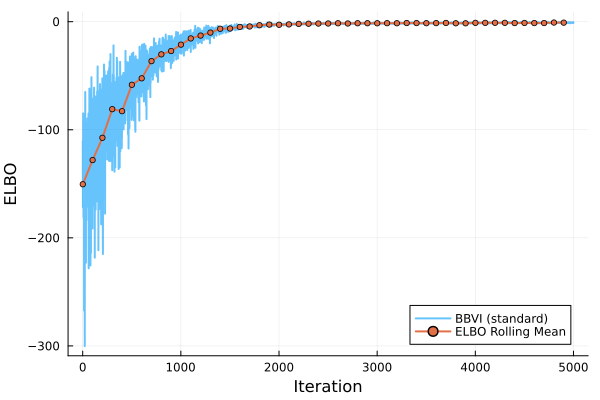

In [45]:
t = [stat.iteration for stat in stats]
y = [stat.elbo for stat in stats]
plot(t, y; label="BBVI (standard)", xlabel="Iteration", ylabel="ELBO", linewidth=2, alpha=0.6)

iters_callback = [stat.iteration for stat in stats if haskey(stat, :elbo_avg)]
elbo_callback = [stat.elbo_avg for stat in stats if haskey(stat, :elbo_avg)]

plot!(iters_callback, elbo_callback, xlabel="Iteration", ylabel="ELBO",  label="ELBO Rolling Mean", linewidth=2, marker=:circle, markersize=3, legend=:bottomright)

#### <center>  **ELBO Maximisation: Linear Bayesian Regression**

In [18]:
folder_path = raw"C:\Users\mussi\Documents\Manhattan\Leuven\MCQMC\Data_Libraries\\"
df_boston = CSV.read(folder_path * "DB_Boston.txt", DataFrame)
M_boston = Matrix(df_boston)
n,p = size(M_boston)


Y = log.(M_boston[:, end])
X = [ones(n,1)  M_boston[:, 1:end-1]]        
X[:,6] = X[:,6].^2
X[:,7] = X[:,7].^2
X[:,9] = log.(X[:,9])
X[:,10] = log.(X[:,10])
X[:,14] = log.(X[:,14]);

In [ ]:
K = size(X, 2)   
d = 1 + K

struct LinearRegressionPrior{T1,T2,T3,T4}
    μ_logσ::T1
    σ_logσ::T2
    μ_coef::T3
    Σ_coef::T4
end

struct LinearRegressionModel{P,TX,TY}
    prior::P
    X::TX
    y::TY
end

function LogDensityProblems.logdensity(p::LinearRegressionPrior, θ::AbstractVector)
    μ_logσ = p.μ_logσ
    σ_logσ = p.σ_logσ
    μ_c    = vec(p.μ_coef)
    Σ_c    = p.Σ_coef

    expected = 1 + length(μ_c)
    length(θ) == expected || throw(ArgumentError("θ length $(length(θ)) != $expected"))

    σ_pos    = θ[1]
    coefs    = vec(θ[2:end])

    return logpdf(LogNormal(μ_logσ, σ_logσ), σ_pos) + logpdf(MvNormal(μ_c, Σ_c), coefs)
end

LogDensityProblems.dimension(m::LinearRegressionPrior) = 1 + length(m.μ_coef)

LogDensityProblems.capabilities(::Type{<:LinearRegressionPrior}) = LogDensityProblems.LogDensityOrder{0}()

function Bijectors.bijector(m::LinearRegressionPrior)
    K = length(m.μ_coef)
    b_σ = Bijectors.bijector(LogNormal(m.μ_logσ, m.σ_logσ))  # unconstrained -> positive
    b_i = identity

    return Bijectors.Stacked((b_σ, b_i), [1:1, 2:(1+K)])
end

function LogDensityProblems.logdensity(m::LinearRegressionModel, θ::AbstractVector)
    # prior part
    lp_prior = LogDensityProblems.logdensity(m.prior, θ)
    # likelihood part
    σ_pos = θ[1]
    coefs = vec(θ[2:end])

    X = m.X
    y = m.y
    n = length(y)

    μ =  X * coefs                 
    lp_like = sum(logpdf.(Normal.(μ, σ_pos), y))

    return lp_prior + lp_like
end

LogDensityProblems.dimension(m::LinearRegressionModel) = LogDensityProblems.dimension(m.prior)

function Bijectors.bijector(m::LinearRegressionModel)
    return Bijectors.bijector(m.prior)
end

prior = LinearRegressionPrior(
    0.0, 1.0,                             # LogNormal su σ
    zeros(K),                             # mean coefficienti
    1.0 * Matrix{Float64}(I, K, K)        # cov coefficienti
)

m_boston = LinearRegressionModel(prior, X, Y);
 
b = Bijectors.bijector(m_boston);          # From the unconstrained to the constrained parameter space
b_inv = Bijectors.inverse(b) 


# Σ0 = Matrix{Float64}(I, d, d) * 0.1
q0 = MeanFieldGaussian(zeros(d), Diagonal(fill(0.1, d)))         # FullRankGaussian(zeros(d), L0)
q0_trans = Bijectors.TransformedDistribution(q0, b_inv)

# μ_init = vcat(std(Y - X * (X \ Y)), vec(X \ Y))           
# L_init = Diagonal(fill(0.01, d))         
# q0 = FullRankGaussian(μ_init, cholesky(Matrix(L_init)).L)
# q0_trans = Bijectors.TransformedDistribution(q0, b_inv)


n_max_iter = 1000
n_montecaro = 20
objective = RepGradELBO(n_montecaro)
opt =  AdvancedVI.DoWG() # Optimisers.Descent

q_avg, q_last, stats, state = AdvancedVI.optimize(m_boston, objective, q0_trans, n_max_iter, show_progress = true, 
                                                  adtype = AutoForwardDiff(), optimizer = opt, 
                                                  operator = ClipScale(),)

nothing

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter C:\Users\mussi\.julia\packages\ProgressMeter\N660J\src\ProgressMeter.jl:607
Optimizing 100%|███████████████████████████████| Time: 0:00:42 (42.39 ms/it)
   iteration: 1000
        elbo: -805.8092506933311


**Optimisers:** https://docs.sciml.ai/Optimization/stable/optimization_packages/optimisers/#List-of-optimizers

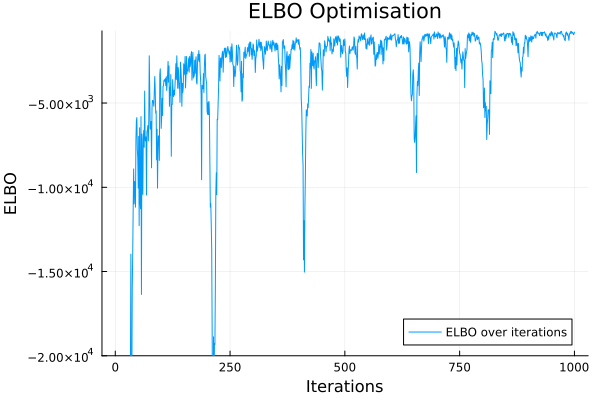

In [45]:
plot([i.elbo for i in stats], xlabel="Iterations", ylabel="ELBO", label="ELBO over iterations", title="ELBO Optimisation", ylims=(-20000, Inf))

# iters_callback = [ s.iteration for s in stats if haskey(s, :elbo_avg) ]
# elbo_callback = [ s.elbo_avg     for s in stats if haskey(s, :elbo_avg) ]
# plot!( iters_callback, elbo_callback, label = "ELBO Rolling Mean", linewidth = 2, marker = :circle, markersize = 3 )

In [44]:
z = rand(q_last, 10^4);
avg = vec(mean(z; dims=2))

15-element Vector{Float64}:
  1.0918889937556484
 -0.0026368830981314683
 -0.0021316267726566433
  0.005713715079908446
 -0.0008315947351770161
  0.0008913488790506525
  0.000810451005256993
  0.017380891755449945
  0.0033060924500260746
 -0.0013338650571978717
 -0.0007025025510810558
  0.0012764424270538574
  0.00844845357324341
  0.0038440251366012516
  0.0021474240075869677

In [46]:
# Y_ols = log.(M_boston[:, end])
# X_ols = [ones(n,1)  M_boston[:, 1:end-1]]        
# X_ols[:,6] = X_ols[:,6].^2
# X_ols[:,7] = X_ols[:,7].^2
# X_ols[:,9] = log.(X_ols[:,9])
# X_ols[:,10] = log.(X_ols[:,10])
# X_ols[:,14] = log.(X_ols[:,14]);
@time ols = lm(X, Y)

  0.005273 seconds (39 allocations: 127.878 KiB)


LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}:

Coefficients:
────────────────────────────────────────────────────────────────────────────
            Coef.   Std. Error       t  Pr(>|t|)     Lower 95%     Upper 95%
────────────────────────────────────────────────────────────────────────────
x1    4.56578      0.154755      29.50    <1e-99   4.26172       4.86984
x2   -0.011835     0.00124547    -9.50    <1e-19  -0.0142821    -0.00938789
x3    5.17744e-5   0.000506807    0.10    0.9187  -0.000944004   0.00104755
x4    4.30655e-5   0.00237506     0.02    0.9855  -0.00462346    0.00470959
x5    0.0912068    0.0332114      2.75    0.0062   0.0259528     0.156461
x6   -0.634756     0.113236      -5.61    <1e-07  -0.857242     -0.41227
x7    0.00628201   0.00131369     4.78    <1e-05   0.00370087    0.00886316
x8    0.000110762  0.00052691     0.21    0.8336  -0.000924515   0.00114604
x9   -0.190859     0.03340

#### **QMC**

In [60]:

using QuasiMonteCarlo
using StatsFuns

qmcrng = SobolSample(; R=OwenScramble(; base=2, pad=32))

function Distributions.rand(
    rng::AbstractRNG, q::MvLocationScale{<:Diagonal,D,L}, num_samples::Int
) where {L,D}
    (; location, scale, dist) = q
    n_dims = length(location)
    scale_diag = diag(scale)
    unif_samples = QuasiMonteCarlo.sample(num_samples, length(q), qmcrng)
    std_samples = norminvcdf.(unif_samples)
    return scale_diag .* std_samples .+ location
end
nothing

In [54]:
n_montecarlo = 8;
objective = RepGradELBO(n_montecarlo)
n_max_iter = 5000
q_avg_qmc, q_qmc, stats_qmc, _ = AdvancedVI.optimize( model, objective, q0_trans, n_max_iter; 
                                                      show_progress=false, adtype=AutoForwardDiff(), 
                                                      callback=callback,);
nothing

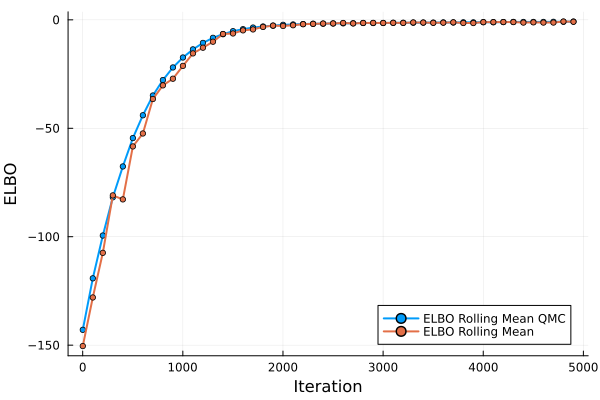

In [55]:
iters_callback_qmc = [stat.iteration for stat in stats_qmc if haskey(stat, :elbo_avg)]
elbo_callback_qmc = [stat.elbo_avg for stat in stats_qmc if haskey(stat, :elbo_avg)]

plot(iters_callback_qmc, elbo_callback_qmc, xlabel="Iteration", ylabel="ELBO",  label="ELBO Rolling Mean QMC", linewidth=2, marker=:circle, markersize=3, legend=:bottomright)
plot!(iters_callback, elbo_callback, xlabel="Iteration", ylabel="ELBO",  label="ELBO Rolling Mean", linewidth=2, marker=:circle, markersize=3, legend=:bottomright)